# Experiments

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

# Load data

In [9]:
INPUT_FOLDER ="../data/processed/after_eda/"

data_train_file = "train_data.csv"
data_test_file = "test_data.csv"

In [10]:
df_train = pd.read_csv(os.path.join(INPUT_FOLDER,data_train_file),sep=";")
df_test = pd.read_csv(os.path.join(INPUT_FOLDER,data_test_file), sep=";")

In [11]:
df_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,pH,sulphates,alcohol,target
0,9.10,0.50,0.30,1.9,0.065,8.0,3.32,0.71,10.5,1
1,5.90,0.37,0.14,6.3,0.036,34.0,3.17,0.63,9.8,0
2,6.20,0.21,0.27,1.7,0.038,41.0,3.49,0.71,10.5,1
3,7.60,0.67,0.14,1.5,0.074,25.0,3.05,0.51,9.3,0
4,7.90,0.20,0.49,1.6,0.053,15.0,3.16,0.47,10.5,0
...,...,...,...,...,...,...,...,...,...,...
5192,7.10,0.22,0.33,2.8,0.033,48.0,3.15,0.38,12.7,1
5193,6.45,0.14,0.42,1.2,0.050,51.0,3.27,0.69,11.1,1
5194,7.70,0.24,0.29,15.3,0.044,39.0,3.06,0.47,9.6,1
5195,6.90,0.24,0.23,7.1,0.041,20.0,3.10,0.85,11.4,1


In [12]:
X_train  = df_train.drop(columns=["target"])
Y_train = df_train["target"]

#Just used to report metrics
X_test = df_test.drop(columns=["target"])
Y_test = df_test["target"]

In [6]:
def plot_distribution(df, text):
    value_counts = df['target'].value_counts()
    plt.bar(value_counts.index, value_counts.values, color=['blue', 'red'], alpha=0.7)
    plt.xticks(value_counts.index)
    plt.title(f'Distribution of Target Value: {text}')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.savefig('target_distribution.png')
    plt.show()

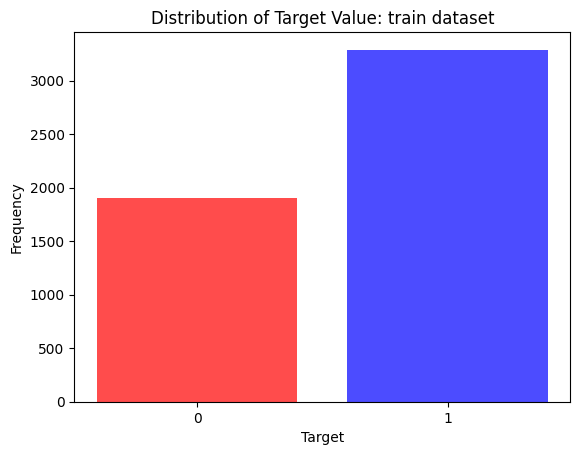

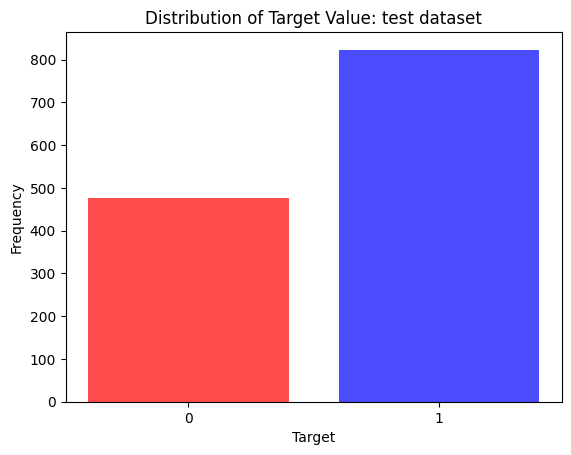

In [33]:
plot_distribution(df_train, text="train dataset")
plot_distribution(df_test, text="test dataset")

Metric: F1-Score

In datasets with imbalanced classes (our case), accuracy can be misleading because a model can achieve high accuracy by simply predicting the majority class. The F1-Score, on the other hand, focuses on the performance of both classes, making it more informative in such scenarios.

In [65]:
from supervised.automl import AutoML

### Experiment global configuration

In [66]:
RANDOM_STATE = 12

validation_strategy= {
                    "validation_type": "kfold",
                    "k_folds": 10,
                    "shuffle": True,
                    "stratify": True,
                    "random_seed": RANDOM_STATE
                }
ml_task = "binary_classification"
eval_metric="f1"
experiment_folder_path = "../experiments"

In [67]:
from sklearn.metrics import auc,roc_curve

def plot_roc_auc(Y_test,Y_pred_proba):

    fpr_0, tpr_0, _ = roc_curve(Y_test, Y_pred_proba[:, 0], pos_label=0)
    roc_auc_0 = auc(fpr_0, tpr_0)

    # Compute ROC curve and ROC area for class 1
    fpr_1, tpr_1, _ = roc_curve(Y_test, Y_pred_proba[:, 1], pos_label=1)
    roc_auc_1 = auc(fpr_1, tpr_1)

    # Plot ROC curves
    fig, ax = plt.subplots()
    ax.plot(fpr_0, tpr_0, color='blue', lw=2, label=f'ROC curve for class 0 (area = {roc_auc_0:.2f})')
    ax.plot(fpr_1, tpr_1, color='red', lw=2, label=f'ROC curve for class 1 (area = {roc_auc_1:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")

    return fig,roc_auc_0,roc_auc_1


In [68]:
from sklearn.metrics import classification_report,auc,confusion_matrix, ConfusionMatrixDisplay


def experiment_report(Y_test, Y_pred, Y_pred_proba):

    confusion_mat_normalized = confusion_matrix(Y_test, Y_pred, normalize="true")
    
    report = classification_report(Y_test, Y_pred, output_dict=True)

    roc_curve_plot,roc_auc_class_0,roc_auc_class_1 = plot_roc_auc(Y_test,Y_pred_proba)

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_normalized,
                                display_labels=[0,1])
    confusion_mat_disp = disp.plot(cmap=plt.cm.Blues)

    

    return confusion_mat_normalized, confusion_mat_disp, report, roc_auc_class_0, roc_auc_class_1,roc_curve_plot

    

In [77]:
def record_mlflow_test_report(automl,experiment_description,Y_pred,Y_pred_proba):


    best_model_type = automl._best_model.get_type()
    best_model_name = automl._best_model.get_name()
    best_model_artifacts_folder = os.path.join(automl._get_results_path(),automl._best_model.get_name())
    best_model_params = automl._best_model.params
    
    confusion_mat_normalized, confusion_mat_disp, report, roc_auc_class_0, roc_auc_class_1,roc_curve_plot = experiment_report(Y_test, Y_pred, Y_pred_proba)
    
    with mlflow.start_run():

        mlflow.log_param("best_model_type", best_model_type)
        mlflow.log_param("best_model_name", best_model_name)
        mlflow.log_param("best_model_params", best_model_params)

        print("best_model_type", best_model_type)
        print("best_model_name", best_model_name)
        print("best_model_params", best_model_params["learner"])

        mlflow.log_param(
            "model_params",best_model_params["learner"]
        )

        mlflow.log_figure(confusion_mat_disp.figure_, 'test_confusion_matrix.png')

        t_n, f_p, f_n, t_p =confusion_mat_normalized.ravel()

        recall_0 = report['0']['recall']
        f1_score_0 = report['0']['f1-score']
        recall_1 = report['1']['recall']
        f1_score_1 = report['1']['f1-score']


        mlflow.log_metric("test_true_positive", t_p)
        mlflow.log_metric("test_true_negative", t_n)
        mlflow.log_metric("test_false_positive", f_p)
        mlflow.log_metric("test_false_negative", f_n)
        mlflow.log_metric("test_recall_0", recall_0)
        mlflow.log_metric("test_f1_score_0", f1_score_0)
        mlflow.log_metric("test_recall_1", recall_1)
        mlflow.log_metric("test_f1_score_1", f1_score_1)

        mlflow.log_metric("test_roc_auc_class_0", roc_auc_class_0)
        mlflow.log_metric("test_roc_auc_class_1", roc_auc_class_1)
        mlflow.log_figure(roc_curve_plot,"test_roc_curve_plot.png")
        
        mlflow.log_metric("train_final_loss",best_model_params["final_loss"])
        mlflow.log_artifact(best_model_artifacts_folder)

        mlflow.log_text(experiment_description,"run_info.txt")

# Experiments


- During the experimentation phase it was decided to use the mljar-supervised tool, which is a automated machine learning Python package designed for working with tabular data. It aims to save time for data scientists by streamlining the common processes of data preprocessing, building machine learning models, and performing hyperparameter tuning to find the optimal model.
- This library handles data normalization internally and selects the appropriate strategy based on the data type. As a result, you won't see any explicit normalization steps applied to the data in the code.
-  All models trained using a K-Fold cross validation, with a K of 10
- The training results of each model are saved in a subfolder within the experiments/ directory, using the format <#_ModelName>. For example, 12_LightGBM indicates that it was the 12th model trained and of type LightGBM. Repeated model names indicate the same model type trained with different hyperparameters.
- Within each model's folder, the following training process graphs are saved:
    - calibration_curve
    - confusion_matrix (calculated with validation data)
    - confusion_matrix_normalized (calculated with validation data)
    - cumulative_gains_curve
    - learning_curves.png (for each fold)
    - roc_curve.png (showing the AUC for each class)
    - permutation_importance.png
Note: Only information from the training process is saved. The training set is internally divided into training and validation subsets, with the validation set used for hyperparameter tuning.

- All trained models use the same training and validation data for each fold, ensuring the comparability of results.
- The results of the model on the unseen test set are saved in MLflow to facilitate result visualization and comparison for decision-making purposes.

The saved information includes:
- test_confusion_matrix.png
- test_roc_curve_plot.png (showing AUC per class)
- train_final_loss (f1)
- test_true_positive, test_true_negative, test_false_positive, test_false_negative, test_recall_0, test_recall_1, test_f1_score_0, test_f1_score_1, test_roc_auc_class_0, test_roc_auc_class_1
- Additionally, all artifacts generated during training will be saved.

To view the MLflow UI, follow these steps:
- Navigate to the notebooks directory:

- cd notebooks/

- Start the MLflow server: mlflow server --host 127.0.0.1 --port 8080

- Open your browser and go to: http://127.0.0.1:8080

Note: Ensure MLflow is installed beforehand (pip install mlflow).


## Experiment 1. Baseline

In [71]:
experiment_name = "1_baseline"

### Train

In [72]:
automl = AutoML(results_path=os.path.join(experiment_folder_path,experiment_name),
                eval_metric=eval_metric,
                train_ensemble=False,
                mode="Perform",
                n_jobs=-1,
                validation_strategy=validation_strategy,
                ml_task=ml_task,
                features_selection=False,
                golden_features=False,
                explain_level=1
                )

In [ ]:
automl.fit(X_train, Y_train)

### Evaluation

In [78]:
Y_pred = automl.predict(X_test)
Y_pred_proba = automl.predict_proba(X_test)

In [79]:
experiment_description = "run first experiment using default params and automl Perform mode, AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'hill_climbing_1', 'hill_climbing_2']"

best_model_type LightGBM
best_model_name 12_LightGBM
best_model_params {'model_type': 'LightGBM', 'ml_task': 'binary_classification', 'n_jobs': -1, 'seed': 1236, 'objective': 'binary', 'num_leaves': 63, 'learning_rate': 0.2, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'min_data_in_leaf': 10, 'metric': 'custom', 'custom_eval_metric_name': 'f1', 'explain_level': 1}


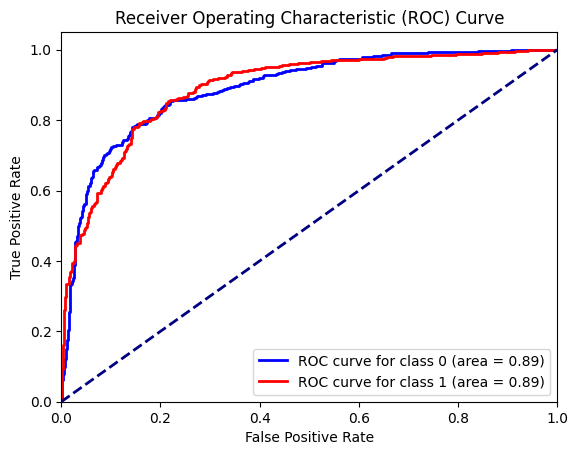

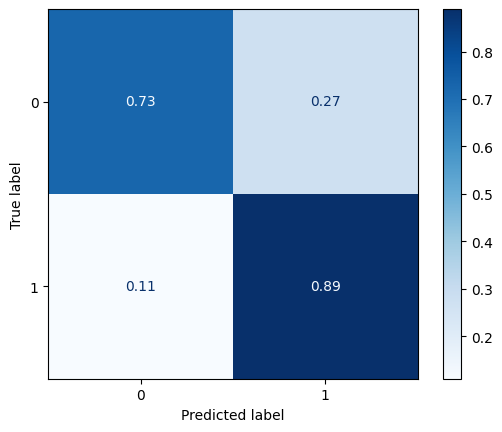

In [80]:
record_mlflow_test_report(automl=automl,
                          experiment_description=experiment_description,
                          Y_pred=Y_pred,
                          Y_pred_proba=Y_pred_proba)

### Conclusions

- Of the 53 experiments(see: [Leaderboard README file](../experiments/1_baseline/README.md)) conducted using various models (Xgboost, RandomForest, CatBoost, LightGBM, Logistic Regression), LightGBM emerged as the best-performing model. The artifacts for this model can be found in experiments/1_baseline/12_LightGBM. The parameter configuration was as follows:

    - **num_leaves**: 63
    - **learning_rate**: 0.2
    - **feature_fraction**: 0.5
    - **bagging_fraction**: 1.0
    - **min_data_in_leaf**: 10

For more information see:[ 12_LightGBM - README file](../experiments/1_baseline/12_LightGBM/README.md)
-  Both classes have an AUC of 0.89, indicating good performance.
- The model demonstrates good performance in distinguishing between the positive and negative classes, as indicated by its performance metrics. An AUC closer to 1 signifies better model capability in differentiating high values in the confusion matrix and ROC curves.
- The ROC AUC values of 0.89 for both classes imply that the model has a strong ability the TPR and FPR, with a steep rise indicating good discriminative ability.

## Experiment 2: LightGBM 

### Train

In [13]:
experiment_name = "LightGBM_HP_improve"

In [14]:
automl = AutoML(results_path=os.path.join(experiment_folder_path,experiment_name),
                algorithms=["LightGBM"],
                eval_metric=eval_metric,
                train_ensemble=False,
                n_jobs=-1,
                validation_strategy=validation_strategy,
                ml_task=ml_task,
                features_selection=False,
                golden_features=False,
                start_random_models=3,
                hill_climbing_steps=3,
                top_models_to_improve=3,
                explain_level=1,
                )

In [15]:
automl.fit(X_train, Y_train)

AutoML directory: ../experiments/LightGBM_HP_improve
The task is binary_classification with evaluation metric f1
AutoML will use algorithms: ['LightGBM']
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'hill_climbing_1', 'hill_climbing_2', 'hill_climbing_3']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_LightGBM f1 0.858327 trained in 29.51 seconds
* Step not_so_random will try to check up to 2 models
2_LightGBM f1 0.833333 trained in 8.64 seconds
3_LightGBM f1 0.866153 trained in 19.1 seconds
* Step hill_climbing_1 will try to check up to 5 models
4_LightGBM f1 0.86565 trained in 21.45 seconds
5_LightGBM f1 0.863095 trained in 19.66 seconds
6_LightGBM f1 0.857227 trained in 22.18 seconds
7_LightGBM f1 0.859122 trained in 25.48 seconds
8_LightGBM f1 0.83376 trained in 9.37 seconds
* Step hill_climbing_2 will try to check up to 6 models
9_LightGBM f1 0.856763 trained in 13.99 se

AutoML(algorithms=['LightGBM'], eval_metric='f1', explain_level=1,
       features_selection=False, golden_features=False, hill_climbing_steps=3,
       ml_task='binary_classification',
       results_path='../experiments/LightGBM_HP_improve', start_random_models=3,
       top_models_to_improve=3, train_ensemble=False,
       validation_strategy={'k_folds': 10, 'random_seed': 12, 'shuffle': True,
                            'stratify': True, 'validation_type': 'kfold'})

### Evaluation

In [16]:
Y_pred = automl.predict(X_test)
Y_pred_proba = automl.predict_proba(X_test)

In [17]:
experiment_description = "LightGBM HP improve"

record_mlflow_test_report(automl=automl,
                          experiment_description=experiment_description,
                          Y_pred=Y_pred,
                          Y_pred_proba=Y_pred_proba)

### Conclusions

##  Experiment 3: Ensemble 

### Train

In [28]:
experiment_name = "esemble"

In [29]:
automl = AutoML(results_path=os.path.join(experiment_folder_path,experiment_name),
                eval_metric=eval_metric,
                algorithms=["Decision Tree","Random Forest","Linear"],
                train_ensemble=True,
                n_jobs=-1,
                validation_strategy=validation_strategy,
                ml_task=ml_task,
                features_selection=False,
                golden_features=False,
                mode="Perform",
                start_random_models=3,
                hill_climbing_steps=3,
                top_models_to_improve=3,
                explain_level=1,
                )

In [30]:
automl.fit(X_train, Y_train)

AutoML directory: ../experiments/esemble
The task is binary_classification with evaluation metric f1
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Linear']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'hill_climbing_1', 'hill_climbing_2', 'hill_climbing_3', 'ensemble']
* Step simple_algorithms will try to check up to 4 models
1_DecisionTree f1 0.795831 trained in 13.66 seconds (1-sample predict time 0.0176 seconds)
2_DecisionTree f1 0.788969 trained in 12.94 seconds (1-sample predict time 0.0167 seconds)
3_DecisionTree f1 0.788969 trained in 12.87 seconds (1-sample predict time 0.0179 seconds)
4_Linear f1 0.80226 trained in 5.05 seconds (1-sample predict time 0.0262 seconds)
* Step default_algorithms will try to check up to 1 model
5_Default_RandomForest f1 0.814575 trained in 9.05 seconds (1-sample predict time 0.1577 seconds)
* Step not_so_random will try to check up to 2 models
6_RandomForest f1 0.

AutoML(algorithms=['Decision Tree', 'Random Forest', 'Linear'],
       eval_metric='f1', explain_level=1, features_selection=False,
       golden_features=False, hill_climbing_steps=3,
       ml_task='binary_classification', mode='Perform',
       results_path='../experiments/esemble', start_random_models=3,
       top_models_to_improve=3,
       validation_strategy={'k_folds': 10, 'random_seed': 12, 'shuffle': True,
                            'stratify': True, 'validation_type': 'kfold'})

### Evaluation

In [31]:
Y_pred = automl.predict(X_test)
Y_pred_proba = automl.predict_proba(X_test)

In [32]:
experiment_description = "emsemble models"

record_mlflow_test_report(automl=automl,
                          experiment_description=experiment_description,
                          Y_pred=Y_pred,
                          Y_pred_proba=Y_pred_proba)


### Conclusions

##  Experiment 5:  LightGBM exploring features


### Train

In [49]:
experiment_description = "LightGBM_exploring_features"


In [50]:
record_mlflow_test_report(automl=automl,
                          experiment_description=experiment_description,
                          Y_pred=Y_pred,
                          Y_pred_proba=Y_pred_proba)

### Conclusions

In [1]:
from sklearn.preprocessing import MinMaxScaler

# Expertiments to do

1. Standarized data
2. just work with: alcohol, volatile_acidity, free_sulfur_dioxide,sulphates